# House Prices - Advanced Regression Techniques 

We are going to do Exploratory Data Analysis on House Price Data.

What You will learn?
* Univariate Analysis
* Bivariate analysis
* Missing value Treatment
* Outlier detecion and treatment
* Dealing with categorical and Numerical variable.
* Feature Selection

If You like the notebook please **Upvote**

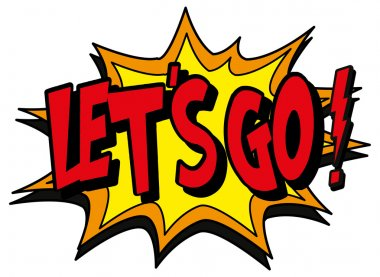

In [ ]:
# Import Libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import missingno as msno
import seaborn as sns

import os
import random

import random

# Statistics
from scipy.stats import norm
from scipy import stats


# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Load Dataset
train=pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
test=pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')
sample=pd.read_csv('../input/house-prices-advanced-regression-techniques/sample_submission.csv')

In [ ]:
train.head()

In [ ]:
train.columns

In [ ]:
sample.head()

In [ ]:
# Description File
with open('../input/house-prices-advanced-regression-techniques/data_description.txt', encoding='utf8') as f:
    for line in f:
        print(line.strip())

In [ ]:
train.describe()

In [ ]:
train.shape

In [ ]:
test.describe()

In [ ]:
test.shape

In [ ]:
train.info()

 Check Missing values

### Missing Values

TRAIN MISSING VALUES

In [ ]:
# show only non-zero missing values
train.isnull().sum()[train.isnull().sum()!=0]

TEST MISSING VALUES

In [ ]:
test.isnull().sum()[test.isnull().sum()!=0]

Now, there are lots of Features. Let's remove `unimportant feature(like ID)` and `Feature with missing values >50%`.

### Remove Features

In [ ]:
features=train.columns
total_houses=train.shape[0]

full=pd.DataFrame()     # columns with no missing values
remove=pd.DataFrame()    # columns with >50% missing values which we have to remove
medium=pd.DataFrame()    # columns with some missing values

for feature in features:
    if train[feature].count() == total_houses:
        full[feature]=train[feature]
    elif train[feature].count() >0.5*total_houses:
        medium[feature]=train[feature]
    else:
        remove[feature]=train[feature]
    

In [ ]:
remove   # Dataframe with feature containg missing values > 50%

### Numerical and Categorical feature

`NUMERICAL`

In [ ]:
print('Number of Numerical feature: ',end=' ')
print(len(train.select_dtypes(include=['number']).columns))        # Return a subset of the DataFrame's columns based on the column dtypes
print('Numerical features:')
print(train.select_dtypes(include=['number']).columns.values)       #number- int +float

In [ ]:
train.describe(exclude=['O'])     # Describe dataframe excluding Object dtype(categorical variable)

`Categorical`

In [ ]:
print('Number of Numerical feature: ',end=' ')
print(len(train.select_dtypes(include=['O']).columns))        # Return a subset of the DataFrame's columns based on the column dtypes
print('Categorical  features:')
print(train.select_dtypes(include=['O']).columns.values)       #number- int +float

### INFERENCE MADE TILL NOW

* **remove**- contain the number of features to be removed from data frame
* **full**- full contain number of features which is full have no missing values.
* **medium**- medium contain features which have some missinf values (less then 50%).
* We have seen there are total of 38 Numerical features and 43 Categorical Fetaures
* **ID**- ID is unnecessary feature we Don't need it.


***What's The Next Step?***

* First we have to Explore each feature.
* Look how the Sales is Distributed.
* Find a Way to fill missing values & remove the features present in remove dataframe.
* Perform EDA & take out the insight from the data.

# Exploratory Data Analysis

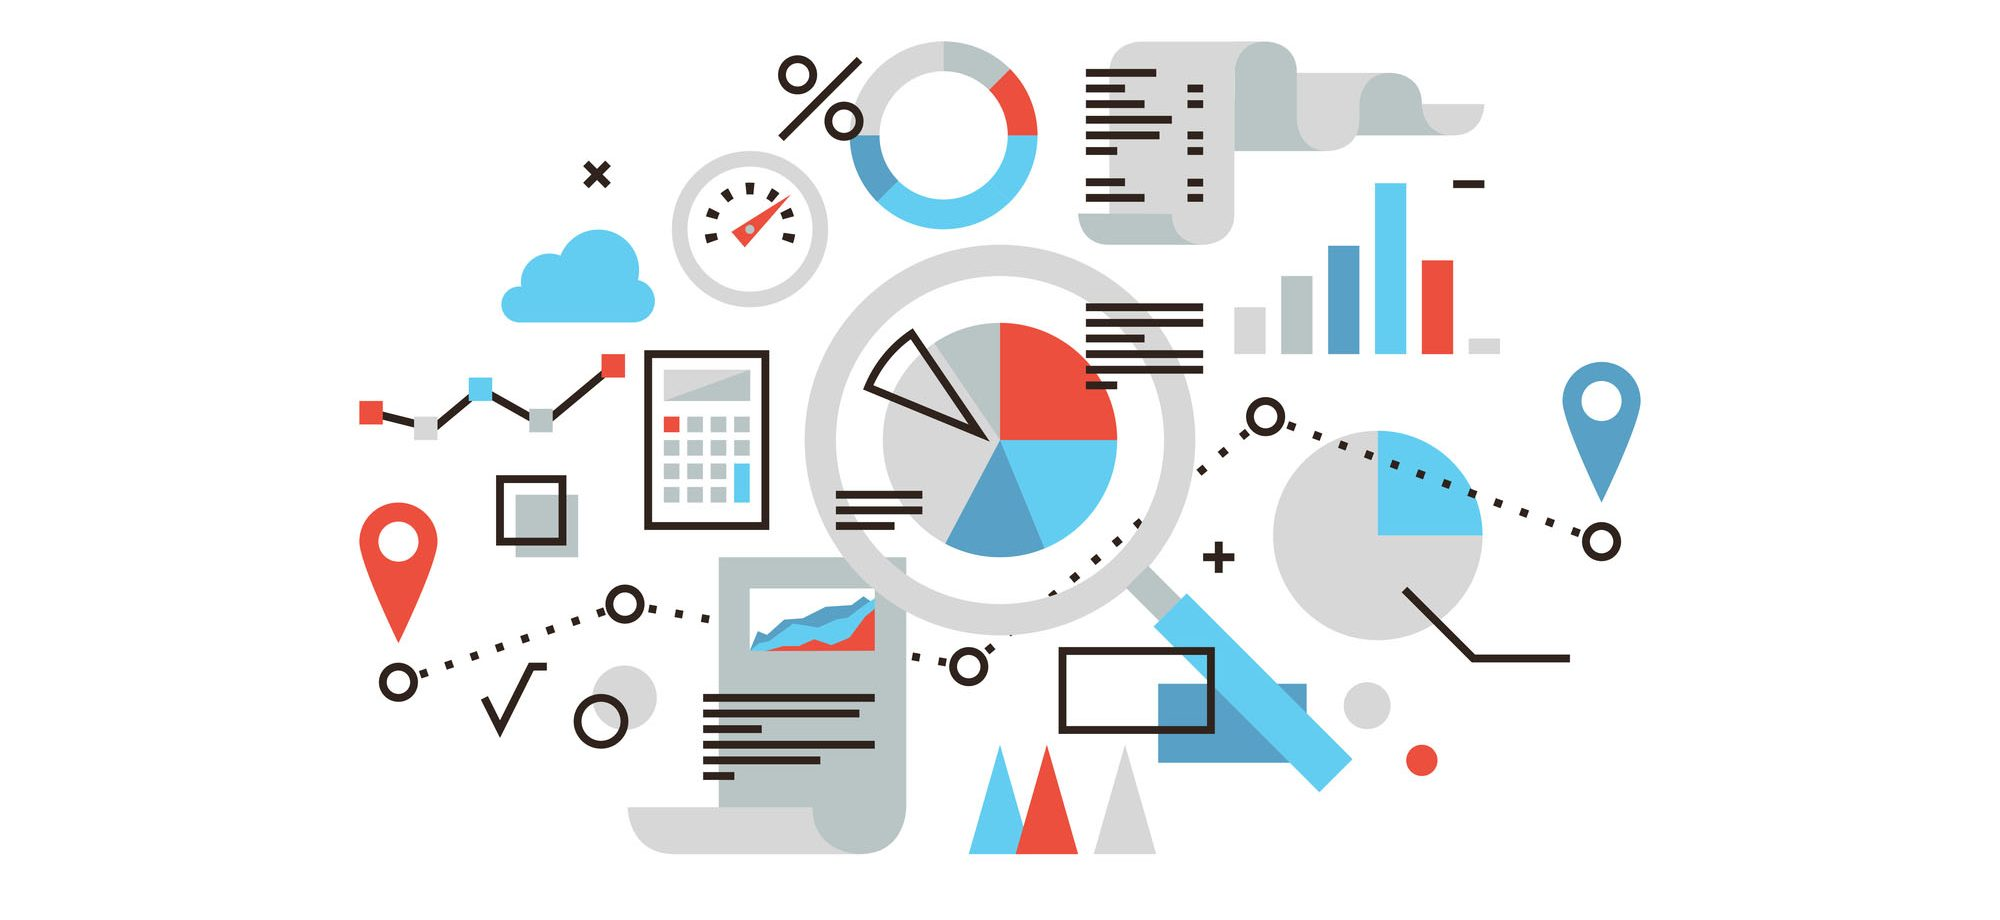

In [ ]:
plt.figure(figsize=(8,8))
plt.hist(train['SalePrice'],bins=50)
plt.title('Sale Prices')
plt.show()

Right Skewed Sales

In [ ]:
print(train['SalePrice'].describe())

In [ ]:
print('Min Sale of the House:',34900)
print('Max Sale of the House:',755000)

Majority of the Sale Price of house lies between 100000 - 200000

Let's drop the Id Feature & remove features

In [ ]:
train.drop(['Id'],axis=1,inplace=True)

train.drop(columns=remove,axis=1,inplace=True)

In [ ]:
train

In [ ]:
# Numerical Feature
df_num=train.select_dtypes(include='number')
df_num

In [ ]:
# Categorical feature
df_cat=train.select_dtypes(include='O')
df_cat

***Let's Plot all the Numerical Features***

In [ ]:
df_num.hist(figsize=(20, 25), bins=50, xlabelsize=8, ylabelsize=8); # 


* As you can see from above histograms some Features like Pool Area, MiscVal, ScreenPorch,3SsnPorof thech and many others have most of the values zero.
* These feature whose most of the values is zero doesn't contribute much to training of the model(less important).
* We remove those features who have >40% values is zero.

In [ ]:
train['PoolArea'].value_counts()

This shows Pool area of most of House=0, It means house doesn'y have any pool.

In [ ]:
# find the rows in column GarageArea whose value is 0
df_num.loc[df_num['GarageArea'] == 0, 'GarageArea']

Similarly find for all featues

In [ ]:
# we want to know the ratio of (values equals zero) / 1460
feature_zero_ratio = {feature:df_num.loc[df_num[feature] == 0, feature].count() / 1460 for feature in df_num.columns.values}
feature_zero_ratio

`Remove features whose feature zero ratio>0.40 (only 40% zeros are allowed)`

In [ ]:
for feature in df_num.columns.values:
    if feature_zero_ratio[feature] > 0.40:
        df_num.drop(columns=feature,axis=1,inplace=True)     # remove feature from df_num,train & medium
        train = train.drop([feature], axis=1)
        if feature in medium:
            medium = medium.drop([feature], axis=1)
            
print(train.shape)
print(df_num.shape)

 # Correlation 

First, Lets also check How Each feature is correlated to `SalePrice`.

In [ ]:
df_num_corr = df_num.corr()['SalePrice'][:-1] # -1 because the latest row is SalePrice
golden_features_list = df_num_corr[abs(df_num_corr) > 0.5].sort_values(ascending=False)
print("There is {} strongly correlated values with SalePrice:\n{}".format(len(golden_features_list), golden_features_list))

Remove some of the Varibales which are highly correlated.

In [ ]:
# Threshold for removing correlated variables
threshold = 0.80

def highlight(value):
    if value > threshold:
        style = 'background-color: pink'
    else:
        style = 'background-color: palegreen'
    return style

# Absolute value correlation matrix
corr_matrix=df_num.corr().abs().round(2)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# print(upper)
upper.style.format("{:.2f}").applymap(highlight)

* `GarageYrBlt` & `YearBuilt`, `TotalBsmtSF` & `1stFlrSF` , `GrLivArea` & `TotalRmsAbvGrd`, `GarageArea` & `Garagecars` all these Pairs are highly Correlated so we can remove one of the feature from these pairs.

In [ ]:
# Select columns with correlations above threshold
collinear_feature=[column for column in upper.columns if any(upper[column]>threshold)]
train.drop(columns=collinear_feature,inplace=True)
df_num.drop(columns=collinear_feature,inplace=True)


Perfect, we now have a list of strongly correlated values but this list is incomplete as we know `that correlation is affected by outliers`. So we could proceed as follow:

Plot the numerical features and see which ones have very few or explainable outliers
Remove the outliers from these features and see which one can have a good correlation without their outliers
Btw, correlation by itself does not always explain the relationship between data so ploting them could even lead us to new insights and in the same manner, check that our correlated values have a linear relationship to the SalePrice.

For example, relationships such as curvilinear relationship cannot be guessed just by looking at the correlation value so lets take the features we excluded from our correlation table and plot them to see if they show some kind of pattern.

In [ ]:
for i in range(0, len(df_num.columns), 5):
    sns.pairplot(data=df_num, x_vars=df_num.columns[i:i+5], y_vars=['SalePrice'])

So, from the above scatterplot of each feature with Sales we can see that most of the features are linearly Correlated with SalePrice.

In [ ]:
print('Number of features left in numerical features:',len(df_num.columns))
print('Numerical Features left:')
print(df_num.columns.values)

In [ ]:
df_num.corr()
plt.figure(figsize=(10,10))
sns.heatmap(df_num.corr(),annot=True, square=True, fmt='.2f', annot_kws={'size':10})

**Last thing from these graphs and heatmaps: we will remove the neutral features**

Neutral Features : features have a relationship with 'SalePrice' in this range [-0.1, 0.2]


In [ ]:
corr_with_price = df_num.corr()
corr_with_price = corr_with_price.sort_values(by= 'SalePrice', ascending=False)
corr_with_price['SalePrice']

### What we have Till Now 🤔

* We have Explored the various types of Numerical feature by plotting it.
* Remove the Numerical features in which Most of the values are Zero indicating the feature is not present in house.
* Draw a correlation matrix and remove the one of the feature from the Pairs which are highy correlated with each other.
* Reduce the Number of Numerical featueres from 38 to 18.

# Handling Missing Data

**Ways of imputing missing values:**

* numerical
1. Deletion of rows of missing value
2. give it the value of the median 
3. give it the value of the mean
4. give it a random value from (mean - std) to (mean + std).

* categorical
1. give it the value of the mode (the most appeared value)
2. do some analysis more, then do step 1 to decrease the ratio of the wrong values

* Some advanced methods of imputation
1. Prediction Model - Make a ML Model to predict the values.
2. KNN Imputation

In [ ]:
numerical_have_missing = pd.DataFrame()
categorical_have_missing = pd.DataFrame()

# Numerical
for feature in df_num.columns.values:
    if feature in medium:
        numerical_have_missing[feature] = df_num[feature]
      
    
# Categorical
for feature in df_cat.columns.values:
    if feature in medium:
        categorical_have_missing[feature] = df_cat[feature]

So, Now we hae 2 dataframes numerical_having_missing_values, categorical_having_missing values which contain columns with missing value for numerical and categorical variable respecctively.

#### Let's Look at the missing Values and try to impute it.

In [ ]:
print(numerical_have_missing.columns)


**According to Data Description Document text:** <br>
**LotFrontage:** Linear feet of street connected to property


In [ ]:
df_num['LotFrontage'].describe()

In [ ]:
df_num['LotFrontage'].hist()

So let's fill missing value with random number number b/w 25%(i.e 59) & 75%(i.e 80).

In [ ]:
old_LotFrontage=list(numerical_have_missing['LotFrontage'].values)
missing_idx=list(numerical_have_missing.loc[ numerical_have_missing['LotFrontage'].isnull(),'LotFrontage'].index)

rand_values=[random.randint(59,80) for i in range(len(missing_idx))]

ind=0
for idx in missing_idx:
    old_LotFrontage[idx]=rand_values[ind]
    ind+=1
    
numerical_have_missing['LotFrontage'] = pd.Series(old_LotFrontage)
train['LotFrontage'] = pd.Series(old_LotFrontage)

print(numerical_have_missing['LotFrontage'].count())
print(train['LotFrontage'].count())

**Now, Lets Come to categorical variable missing values**

In [ ]:
print(categorical_have_missing.columns.values)

In [ ]:
categorical_have_missing.isnull().sum()

In [ ]:
print('Total categorical missing values:',len(categorical_have_missing.isnull().sum()))

Now, let's plot each category variable and try to impute the missing value.

In [ ]:
fig, axes = plt.subplots(round(len(categorical_have_missing.columns) / 4), 4, figsize=(18, 10))

for i, ax in enumerate(fig.axes):
    if i < len(categorical_have_missing.columns):
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
        sns.countplot(x=categorical_have_missing.columns[i], alpha=0.7, data=categorical_have_missing, ax=ax)

fig.tight_layout()      # Adjust the padding between and around subplots.

Since `FireplaceQu` has 690 missing value so it is better to remove this and for rest of the categorical variable fill the missing value with mode.

In [ ]:
categorical_have_missing.drop(['FireplaceQu'],axis=1,inplace=True)
train.drop(['FireplaceQu'],axis=1,inplace=True)

In [ ]:
imputer=SimpleImputer(missing_values=np.NaN,strategy='most_frequent')
for feature in categorical_have_missing.columns:
    categorical_have_missing[feature]=imputer.fit_transform(categorical_have_missing[feature].values.reshape(-1,1))
    train[feature]=imputer.fit_transform(train[feature].values.reshape(-1,1))
    

In [ ]:
train.isnull().sum()

In [ ]:
train.shape

No Missing values & removed unwanted features

# Outliers 

**Outliers** are of 2 types Univariate and Multivariate Outlier.
* Univariate: These outliers can be found when we look at distribution of a single variable.(Boxplot)
* Multivariate outliers- are outliers in an n-dimensional space. In order to find them, you have to look at distributions in multi-dimensions.(scatterplot).


It's time to deal with outliers.<br>
Now, Question arises how?

**Method of removing outlier**
* Deleting observations
* Transform and binning values- Transforming variables can also eliminate outliers. Natural log of a value reduces the variation caused by extreme values. 
* Imputing - Like imputing  missing values we can also impute outliers with mean, median & mode.
* Treat separately: If there are significant number of outliers, we should treat them separately in 3 the statistical model. One of the approach is to treat both groups as two different groups and build individual model for both groups and then combine the output.



In [ ]:
for i in range(0, len(df_num.columns), 5):
    plt.figure(figsize=(15,15))
    sns.pairplot(data=df_num, x_vars=df_num.columns[i:i+5], y_vars=['SalePrice'])

As We can see from above scatter plots we have some outliers and since there are few we are gone a delete them.
* Lotfrontage - 2 outliers
* LotArea- Let's consider the rightmost 3 dots as outliers.
* BsmtFinSF1 - 1 outlier
* TotalBsmtSF - 1 outlier
* GrLivArea- Righmost 2 dots with lower SalePrice are outliers.

In [ ]:
outlier_indices=[]

In [ ]:
outlier_indices.extend(list(train[train['LotFrontage']>250].index))

In [ ]:
plt.scatter(train['LotArea'],train['SalePrice'])

In [ ]:
outlier_indices.extend(list(train[train['LotArea']>150000].index))

In [ ]:
outlier_indices.extend(list(train[(train['BsmtFinSF1']>4000) | (train['TotalBsmtSF']>4000) | ((train['GrLivArea']>4000) & (train['SalePrice']<400000))].index))

In [ ]:
outlier_indices     

In [ ]:
train.drop(train.index[outlier_indices],inplace=True)

In [ ]:
train

In [ ]:
train.reset_index(drop=True,inplace=True)

**Hurray! we have completely remove outliers.**

# Some Statistics

I would like to thank [this Notebook](https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python) for this amazing statistical analysis.

 Who is 'SalePrice'?

The answer to this question lies in testing for the assumptions underlying the statistical bases for multivariate analysis. We already did some data cleaning and discovered a lot about 'SalePrice'. Now it's time to go deep and understand how 'SalePrice' complies with the statistical assumptions that enables us to apply multivariate techniques.

According to Hair et al. (2013), four assumptions should be tested:

* Normality - When we talk about normality what we mean is that the data should look like a normal distribution. This is important because several statistic tests rely on this (e.g. t-statistics). In this exercise we'll just check univariate normality for 'SalePrice' (which is a limited approach). Remember that univariate normality doesn't ensure multivariate normality (which is what we would like to have), but it helps. Another detail to take into account is that in big samples (>200 observations) normality is not such an issue. However, if we solve normality, we avoid a lot of other problems (e.g. heteroscedacity) so that's the main reason why we are doing this analysis.

* Homoscedasticity - I just hope I wrote it right. Homoscedasticity refers to the 'assumption that dependent variable(s) exhibit equal levels of variance across the range of predictor variable(s)' (Hair et al., 2013). Homoscedasticity is desirable because we want the error term to be the same across all values of the independent variables.

* Linearity- The most common way to assess linearity is to examine scatter plots and search for linear patterns. If patterns are not linear, it would be worthwhile to explore data transformations. However, we'll not get into this because most of the scatter plots we've seen appear to have linear relationships.

* Absence of correlated errors - Correlated errors, like the definition suggests, happen when one error is correlated to another. For instance, if one positive error makes a negative error systematically, it means that there's a relationship between these variables. This occurs often in time series, where some patterns are time related. We'll also not get into this. However, if you detect something, try to add a variable that can explain the effect you're getting. That's the most common solution for correlated errors.



* Histogram - Kurtosis and skewness.
* Normal probability plot - Data distribution should closely follow the diagonal that represents the normal distribution.

In [ ]:
    sns.distplot(train['SalePrice'],fit=norm)
    plt.figure()
    res=stats.probplot(train['SalePrice'],plot=plt)

Ok, 'SalePrice' is not normal. It shows 'peakedness', positive skewness and does not follow the diagonal line.

But everything's not lost. A simple data transformation can solve the problem. This is one of the awesome things you can learn in statistical books: in case of positive skewness, log transformations usually works well.

In [ ]:
train['SalePrice']=np.log(train['SalePrice'])

Now, after doing Log Transformation Let's check again.

In [ ]:
    sns.distplot(train['SalePrice'],fit=norm)
    plt.figure()
    res=stats.probplot(train['SalePrice'],plot=plt)

Now, Sale Price follow Normal distribution.

In [ ]:
#histogram and normal probability plot
sns.distplot(train['GrLivArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(train['GrLivArea'], plot=plt)

In [ ]:
#data transformation
train['GrLivArea'] = np.log(train['GrLivArea'])

In [ ]:
#histogram and normal probability plot
sns.distplot(train['GrLivArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(train['GrLivArea'], plot=plt)

# Label Encoding (Change categorical variable into Label encoding)

**Label Encoder**: It is used to transform non-numerical labels to numerical labels (or nominal categorical variables). Numerical labels are always between 0 and n_classes-1. 

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
df_cat=train.select_dtypes(include='O')

In [ ]:
le=LabelEncoder()
for feature in df_cat.columns.values:
    df_cat[feature]=le.fit_transform(df_cat[feature])
    train[feature]=le.fit_transform(train[feature])


In [ ]:
train.info()

NOW, Each variable is converted to numeric type

# Let's do Model Training

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [ ]:
target = train['SalePrice']
train = train.drop(['SalePrice'], axis=1)

X, y = train, target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Multivariate Linear regressor

In [ ]:
lr=LinearRegression()
lr.fit(X_train,y_train)
y_pred=lr.predict(X_test)
lr.score(X_train,y_train)           # Return the coefficient of determination R^2 of the prediction

In [ ]:
np.sqrt(mean_squared_log_error(y_pred, y_test))

In [ ]:
y_test

### Plot the original y and the predicted output ‘y_pred’

In [ ]:
plt.figure()
plt.scatter(x=list(range(0, 291)),y= y_test, color='blue')         
plt.scatter(x=list(range(0, 291)),y= y_pred, color='black')
plt.show()

Some of the output points are almost overlapping with the predicted outputs. Some are close but not overlapping.

# Random Forest regressor

Now, we will use Random Forest regressor with Bayesian optimization for hyperparameter tuning.

Thanks to utility function bayesian optimization is much more efficient in tuning parameters of machine learning algorithms than grid or random search techniques. It can effectively balance “exploration” and “exploitation” in finding global optimum.

To present Bayesian optimization in action we use BayesianOptimization library written in Python to tune hyperparameters of Random Forest and XGBoost classification algorithms. We need to install it via pip:

In [ ]:
pip install bayesian-optimization

In [ ]:
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score

In [ ]:
#Bayesian optimization
def bayesian_optimization(dataset, function, parameters):
   X_train, y_train, X_test, y_test = dataset
   n_iterations = 10
   gp_params = {"alpha": 1e-4}

   BO = BayesianOptimization(function, parameters)
   BO.maximize(n_iter=n_iterations, **gp_params)

   return BO.max


In [ ]:
def rfc_optimization(cv_splits):
    def function(n_estimators, max_depth, min_samples_split):
        return cross_val_score(
               RandomForestRegressor(
                   n_estimators=int(max(n_estimators,0)),                                                               
                   max_depth=int(max(max_depth,1)),
                   min_samples_split=int(max(min_samples_split,2)), 
                   n_jobs=-1, 
                   random_state=42),  
               X=X_train, 
               y=y_train, 
               cv=cv_splits,
               scoring='neg_mean_squared_log_error',
               n_jobs=-1).mean()

    parameters = {"n_estimators": (10, 1000),
                  "max_depth": (1, 150),
                  "min_samples_split": (2, 20)}
    
    return function, parameters

In [ ]:
#Train model
def train_rf(X_train, y_train, X_test, y_test, function, parameters):
    dataset = (X_train, y_train, X_test, y_test)
#     cv_splits = 4
    
    best_solution = bayesian_optimization(dataset, function, parameters)      
    params = best_solution["params"]

    model = RandomForestRegressor(
             n_estimators=int(max(params["n_estimators"], 0)),
             max_depth=int(max(params["max_depth"], 1)),
             min_samples_split=int(max(params["min_samples_split"], 2)), 
             n_jobs=-1, 
             random_state=42)

    model.fit(X_train, y_train)
    
    return model

In [ ]:
func_rf,param_rf=rfc_optimization(10)
rf_bo=train_rf(X_train, y_train, X_test, y_test, func_rf, param_rf)

In [ ]:
rf_bo.get_params

In [ ]:
y_pred=rf_bo.predict(X_test)

In [ ]:
print(y_pred.shape)

In [ ]:
print('Root Mean Squared Error in Random Forest:', np.sqrt(mean_squared_log_error(y_test, y_pred)))

In [ ]:
pred=rf_bo.predict(X_test)

In [ ]:
print('Root Mean Squared Error in Random Forest:', np.sqrt(mean_squared_log_error(y_test, pred)))

In [ ]:
importances=rf_bo.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_bo.estimators_],axis=0)
indices = np.argsort(importances)

In [ ]:
# Plot the feature importances of the forest
plt.figure(figsize=(20,15))
plt.title("Feature importances")
plt.barh(range(X_train.shape[1]), importances[indices],
       color="r", xerr=std[indices], align="center")
# If you want to define your own labels,
# change indices to a list of labels on the following line.
plt.yticks(range(X.shape[1]), indices)
plt.ylim([-1, X.shape[1]])
plt.show()

In [ ]:
plt.figure(figsize=(20,15))
(pd.Series(rf_bo.feature_importances_, index=X_train.columns).plot(kind='barh',color='red')) 

# XGBOOST MODEL

In [ ]:
def xgb_optimization(cv_splits, eval_set):
    def function(eta, gamma, max_depth,n_estimators):
            return cross_val_score(
                       XGBRegressor(
                       objective="reg:squaredlogerror",
                       n_estimators=int(max(n_estimators,0)),
                       learning_rate=max(eta, 0),
                       gamma=max(gamma, 0),
                       max_depth=int(max_depth),                                               
                       seed=42,
                       n_jobs=-1),  
                   X=X_train, 
                   y=y_train, 
                   cv=cv_splits,
                   scoring="neg_mean_squared_log_error",
#                    fit_params={
#                         "early_stopping_rounds": 10, 
#                         "eval_metric":"reg:squaredlogerror", 
#                         "eval_set": eval_set},
                   n_jobs=-1).mean()

    parameters = {"eta": (0.001, 0.4),
                  "gamma": (0, 20),
                  "max_depth": (1, 2000),
                  "n_estimators":(10,1000)}
    
    return function, parameters

In [ ]:
def train_xgb(X_train, y_train, X_test, y_test, function, parameters):
    dataset = (X_train, y_train, X_test, y_test)
#     cv_splits = 4
    
    best_solution = bayesian_optimization(dataset, function, parameters)      
    params = best_solution["params"]

    model = XGBRegressor(
             n_estimators=int(max(params["n_estimators"], 0)),
             max_depth=int(max(params["max_depth"], 1)),
             
             n_jobs=-1, 
             random_state=42)

    model.fit(X_train, y_train)
    
    return model

In [ ]:
func_xgb,param_xgb=xgb_optimization(10,y_train)
xgb_bo=train_xgb(X_train, y_train, X_test, y_test, func_xgb, param_xgb)

In [ ]:
predXGB=xgb_bo.predict(X_test)

In [ ]:
print('Root Mean Squared Error in Random Forest:', np.sqrt(mean_squared_log_error(y_test, predXGB)))

# Submission

In [ ]:
print(test.info())

In [ ]:
ids = test['Id']

In [ ]:
test= test[train.columns.values]
# Delete Id again
# train= train.drop(['Id'], axis=1)

In [ ]:
test

In [ ]:
# Let's code it
old_LotFrontage = list(test['LotFrontage'].values)
missing_indices = list(test.loc[test['LotFrontage'].isnull(), 'LotFrontage'].index)
random_values = [random.randint(60, 80) for _ in range( 1460 - test['LotFrontage'].count() ) ]
random_values_idx = 0

for missing_idx in missing_indices:
        
    old_LotFrontage[missing_idx] = random_values[random_values_idx]
    random_values_idx += 1
        

test['LotFrontage'] = pd.Series(old_LotFrontage)
print(test['LotFrontage'].count())

In [ ]:
 imputer = SimpleImputer(missing_values=np.NaN, strategy='most_frequent')
for feature in test.drop(['LotFrontage'], axis=1):
    
    test[feature] = imputer.fit_transform(test[feature].values.reshape((-1, 1)))
    test[feature] = imputer.fit_transform(test[feature].values.reshape((-1, 1)))
    
le=LabelEncoder()
for feature in df_cat.columns.values:
    test[feature]=le.fit_transform(test[feature])
print(test.isnull().sum().max())
print(test.shape)

In [ ]:
rest = set(X.columns.values) - set(list(test.columns.values))
for feature in list(rest):
    test[feature] = 0

In [ ]:

# test = test.drop(['Id'], axis=1)
ourPred = xgb_bo.predict(test)
submission = pd.DataFrame({
        "Id": ids,
        "SalePrice": ourPred
    })
submission.to_csv('submission.csv', index=False)

In [ ]:
submission

THANKS TO:
* https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python#5.-Getting-hard-core
* https://www.kaggle.com/mostafaalaa123/simple-house-prediction/notebook#ML 
    

#### IF YOU GAIN SOME KNOWLEDGE PLEASE UPVOTE THE NOTEBOOK.